#Batch normalization Implementation in MNIST

- Batch normalization을 사용하여 Mnist dataset을 학습한다.
- Batch normalizatoin을 사용하지 않은 모델과 결과를 비교해 본다.

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import tensorflow as tf
import cv2

- Batch normalization wrapper 함수 선언

In [0]:
def batch_normalization(inputs, is_train, decay=0.999, epsilon=1e-5):    
    #input shape의 feature size측정
    sizes = inputs.get_shape()[-1]
    
    #test를 위한 moving average를 계산위함, 초기값은 0으로 지정 : tf.zeros
    test_mean = tf.Variable(tf.zeros([sizes]), name = 'test_mean')
    test_var = tf.Variable(tf.zeros([sizes]), name = 'test_var')
    
    # featuare갯수만큼 scale factor와 shiftf factor
    gamma = tf.Variable(tf.ones(sizes), name='scale_factor')
    beta = tf.Variable(tf.zeros(sizes), name='shift_factor')

    def train():
        mean, var = tf.nn.moments(inputs, [0])
        updated_mean = tf.assign(test_mean, 
                                 (((1-decay) * mean) + (decay*(test_mean))))
        updated_var = tf.assign(test_var,
                                (((1-decay) * var) + (decay*(test_var))))
        
        with tf.control_dependencies([updated_mean ,updated_var]) :
            xs_bn = tf.nn.batch_normalization(inputs, mean, var, 
                                              beta, gamma, epsilon)
            
            #xs_norm = (xs - mean) /tf.sqrt(var+eps)
            #xs_bn = (xs_norm * gamma) + beta
            
            return xs_bn    
    
    def test():
        #test할때나 train할때나 beta gamma는 동일함
        #xs_norm = (xs - test_mean) / tf.sqrt(test_var+eps)
        #xs_bn = (xs_norm*gamma) + beta
        #high api사용
        xs_bn = tf.nn.batch_normalization(inputs, test_mean, test_var,
                                          beta, gamma, epsilon)
        
        return xs_bn
        
    xs_bn = tf.cond(is_train, train, test)
    
    return xs_bn

- MNIST load하기

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist/',one_hot=False)

W0626 17:41:06.221261 140224608143232 deprecation.py:323] From <ipython-input-3-219623c18e16>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0626 17:41:06.223013 140224608143232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0626 17:41:06.223962 140224608143232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting mnist/train-images-idx3-ubyte.gz


W0626 17:41:06.507084 140224608143232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0626 17:41:06.558336 140224608143232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [0]:
train_set = mnist.train
valid_set = mnist.validation
test_set = mnist.test

## Batch normalization 없는 모델로 MINST학습해보기

In [5]:
graph = tf.Graph()
with graph.as_default():
    xs = tf.placeholder(dtype = tf.float32, shape=[None,784])
    la = tf.placeholder(dtype = tf.int32, shape=[None,])
    lr = 0.0001
    
    layer1 = tf.layers.Dense(units = 1500, activation = tf.nn.relu,
                             use_bias=False,
                             kernel_initializer=tf.initializers.he_normal())(xs)
    layer2 = tf.layers.Dense(units = 500, activation = tf.nn.relu,
                             use_bias=True,
                             kernel_initializer=tf.initializers.he_normal(),
                             bias_initializer=tf.initializers.zeros)(layer1)
    layer3 = tf.layers.Dense(units = 100, activation = tf.nn.relu,
                             use_bias=False,
                             kernel_initializer=tf.initializers.he_normal(),
                            bias_initializer=tf.initializers.zeros)(layer2)
    layer4 = tf.layers.Dense(units = 10, activation = None,
                             use_bias=False,
                             kernel_initializer=tf.initializers.he_normal(),
                            bias_initializer=tf.initializers.zeros)(layer3)
    
    loss = tf.losses.sparse_softmax_cross_entropy(la, layer4)
    trian_op = tf.train.AdamOptimizer(lr).minimize(loss)

W0626 17:41:07.170989 140224608143232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
num_epoch = 100
num_batch = 60
num_step = train_set.num_examples // num_batch

acc_history_without_bn = []

with graph.as_default():
    sess = tf.Session(graph=graph)
    sess.run([tf.global_variables_initializer()])
    
    for epoch in range(num_epoch):
        da, lab = train_set.next_batch(num_batch)
        _, loss_ = sess.run([trian_op, loss],
                            feed_dict = {xs : da,
                                        la : lab})
        if epoch % 10 == 0 :
            print(loss_)
        acc_history_without_bn.append(loss_)

2.5211272
1.8639576
1.428736
1.0832905
0.8033156
0.6441187
0.43896312
0.4992115
0.7062502
0.28772742


- 시각화하기

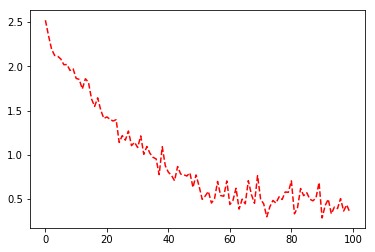

In [7]:
plt.plot(acc_history_without_bn, 'r--')

## Batch normalization 적용한 모델로 MINST학습하기

- Batch normalization을 사용한 dense network를 구현한다

In [0]:
def dense_bn_relu(inputs, is_train, filters, name='dense'):
    # (1) Logit 계산 -> (2) Batch Normalization 적용 -> (3) 활성화함수 
    # 순으로 연산하는 메소드
        layer = tf.layers.Dense(filters, use_bias=False)(inputs)
        bn = batch_normalization(layer, is_train)
        
        return tf.nn.relu(bn)

In [9]:
graph = tf.Graph()
with graph.as_default():
    xs = tf.placeholder(dtype = tf.float32, shape=[None,784])
    la = tf.placeholder(dtype = tf.int32, shape=[None,])
    lr = 0.0001
    is_train =  tf.placeholder(dtype = tf.bool)
    
    layer1 = tf.layers.Dense(units = 1500, activation = tf.nn.relu,
                             use_bias=False,
                             kernel_initializer=tf.initializers.he_normal())(xs)
    
    bn_layer2 = dense_bn_relu(layer1, is_train, 500)
    bn_layer3 = dense_bn_relu(bn_layer2, is_train, 100)
    layer4 = tf.layers.Dense(10, activation=None ,use_bias=False)(bn_layer3)    
    
    loss = tf.losses.sparse_softmax_cross_entropy(la, layer4)
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)

W0626 17:41:10.142095 140224608143232 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
num_epoch = 100
num_batch = 60
num_step = train_set.num_examples // num_batch

acc_history_with_bn = []

with graph.as_default():
    sess2 = tf.Session()
    sess2.run(tf.global_variables_initializer())
    for i in range(num_epoch) :
        da, lab = train_set.next_batch(num_batch)
        _, loss_ = sess2.run([train_op, loss], feed_dict = {xs : da,
                                                la : lab,
                                                is_train : True})
        acc_history_with_bn.append(loss_)
        if i % 10 == 0 :
            print(loss_)

3.071334
1.511061
0.98626477
0.7577753
0.6855252
0.75739163
0.76143926
0.6102547
0.5185818
0.6468473


- 두 모델의 loss 함수 변화를 시각화

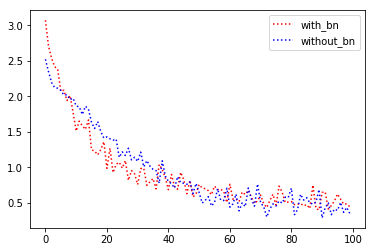

In [11]:
plt.plot(acc_history_with_bn, label='with_bn',color='r', linestyle=':')
plt.plot(acc_history_without_bn, label='without_bn', color = 'b', linestyle=':')
plt.legend()
plt.show()

배치노말 레이어가 있었을 때, 훨씬 더 빠르게 수렴함을 알 수 있다.